# Set Up

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import shap

# Load the dataset

In [78]:
df = pd.read_csv("/Users/lilitpoghosyan/Downloads/creditcard.csv")
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Data quality checks

In [79]:
df.info()
print("\nMissing values:\n", df.isna().sum().sort_values(ascending=False).head(10))
print("\nDuplicate rows:", df.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# Class imbalance check

In [80]:
class_counts = df["Class"].value_counts()
class_rates = df["Class"].value_counts(normalize=True)
print("Counts:\n", class_counts)
print("\nRates:\n", class_rates)

Counts:
 Class
0    284315
1       492
Name: count, dtype: int64

Rates:
 Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


# Imbalance bar

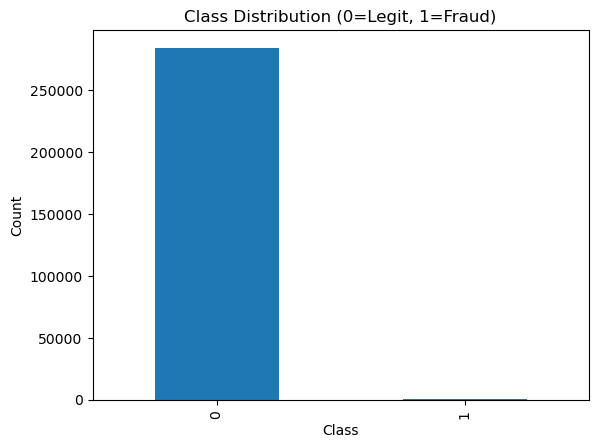

In [81]:
plt.figure()
class_counts.plot(kind="bar")
plt.title("Class Distribution (0=Legit, 1=Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# Time & Amount distributions (with fraud overlay)

This dataset has Time (seconds since first transaction) and Amount.

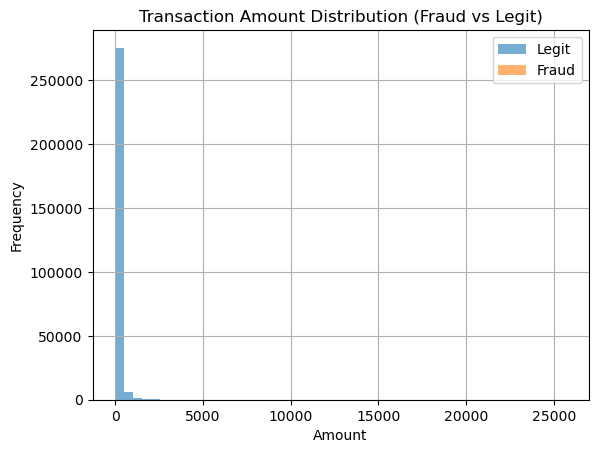

In [82]:
plt.figure()
plt.hist(df.loc[df["Class"] == 0, "Amount"], bins=50, alpha=0.6, label="Legit")
plt.hist(df.loc[df["Class"] == 1, "Amount"], bins=50, alpha=0.6, label="Fraud")
plt.title("Transaction Amount Distribution (Fraud vs Legit)")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()

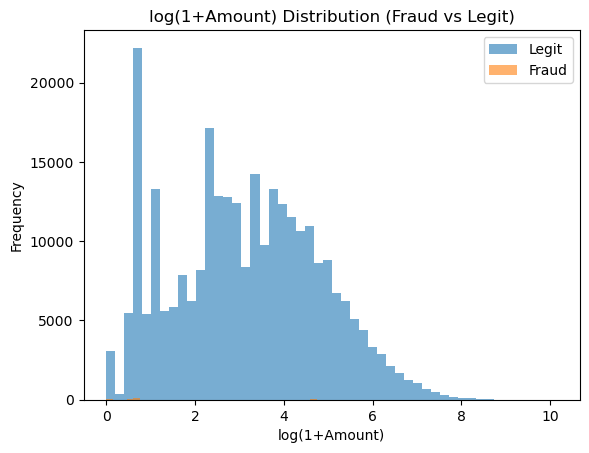

In [83]:
plt.figure()
plt.hist(np.log1p(df.loc[df["Class"] == 0, "Amount"]), bins=50, alpha=0.6, label="Legit")
plt.hist(np.log1p(df.loc[df["Class"] == 1, "Amount"]), bins=50, alpha=0.6, label="Fraud")
plt.title("log(1+Amount) Distribution (Fraud vs Legit)")
plt.xlabel("log(1+Amount)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

Time:

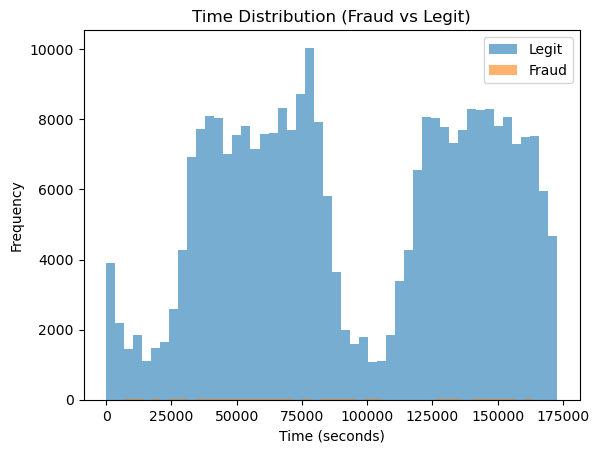

In [84]:
plt.figure()
plt.hist(df.loc[df["Class"] == 0, "Time"], bins=50, alpha=0.6, label="Legit")
plt.hist(df.loc[df["Class"] == 1, "Time"], bins=50, alpha=0.6, label="Fraud")
plt.title("Time Distribution (Fraud vs Legit)")
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Train/Test split

In [85]:
X = df.drop(columns=["Class"])
y = df["Class"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape, "Fraud rate:", y_train.mean())
print("Test shape :", X_test.shape,  "Fraud rate:", y_test.mean())

Train shape: (227845, 30) Fraud rate: 0.001729245759178389
Test shape : (56962, 30) Fraud rate: 0.0017204452090867595


# Baseline metric functions

In [86]:
def evaluate_scores(y_true, y_proba, threshold=0.5):
    y_pred = (y_proba >= threshold).astype(int)

    roc = roc_auc_score(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)

    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, digits=4)

    return {"roc_auc": roc, "pr_auc": ap, "confusion_matrix": cm, "report": report}

# Logistic Regression baseline

In this dataset:

V1–V28 are already PCA-scaled, Amount and Time are not. We scale only what needs scaling.

In [87]:
pca_features = [c for c in X_train.columns if c.startswith("V")]
scale_features = ["Amount", "Time"]

# Preprocessing + model pipeline

In [88]:
preprocessor = ColumnTransformer(
    transformers=[
        ("scale", StandardScaler(), scale_features),
        ("pass", "passthrough", pca_features)
    ])

In [89]:
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight="balanced",   
    solver="lbfgs",
    n_jobs=-1
)

pipe_lr = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", log_reg)
])

In [90]:
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('scale', StandardScaler(),
                                                  ['Amount', 'Time']),
                                                 ('pass', 'passthrough',
                                                  ['V1', 'V2', 'V3', 'V4', 'V5',
                                                   'V6', 'V7', 'V8', 'V9',
                                                   'V10', 'V11', 'V12', 'V13',
                                                   'V14', 'V15', 'V16', 'V17',
                                                   'V18', 'V19', 'V20', 'V21',
                                                   'V22', 'V23', 'V24', 'V25',
                                                   'V26', 'V27', 'V28'])])),
                ('model',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    n_jobs=-1))])

In [91]:
y_test_proba = pipe_lr.predict_proba(X_test)[:, 1]

In [92]:
baseline_results = evaluate_scores(y_test, y_test_proba, threshold=0.5)

print("ROC-AUC:", baseline_results["roc_auc"])
print("PR-AUC :", baseline_results["pr_auc"])
print("\nConfusion Matrix:\n", baseline_results["confusion_matrix"])
print("\nClassification Report:\n", baseline_results["report"])

ROC-AUC: 0.9721687370080279
PR-AUC : 0.7159122424484009

Confusion Matrix:
 [[55478  1386]
 [    8    90]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9999    0.9756    0.9876     56864
           1     0.0610    0.9184    0.1144        98

    accuracy                         0.9755     56962
   macro avg     0.5304    0.9470    0.5510     56962
weighted avg     0.9982    0.9755    0.9861     56962



In [93]:
y_pred_default = (y_test_proba >= 0.5).astype(int)
print("Accuracy:", accuracy_score(y_test, y_pred_default))

Accuracy: 0.9755275446789088


Accuracy is misleading in fraud detection due to extreme class imbalance, so I focus on recall, precision and PR-AUC.

# Threshold tuning

In [94]:
thresholds = np.linspace(0.001, 0.5, 20)

rows = []

for t in thresholds:
    res = evaluate_scores(y_test, y_test_proba, threshold=t)
    tn, fp, fn, tp = res["confusion_matrix"].ravel()

    rows.append({
        "threshold": t,
        "precision": tp / (tp + fp + 1e-9),
        "recall": tp / (tp + fn + 1e-9),
        "false_positives": fp,
        "true_positives": tp
    })

threshold_df = pd.DataFrame(rows)
threshold_df

,threshold,precision,recall,false_positives,true_positives
0,0.001000,0.001847,1.000000,52962,98
1,0.027263,0.003583,0.989796,26976,97
2,0.053526,0.005201,0.959184,17980,94
3,0.079789,0.006810,0.948980,13563,93
4,0.106053,0.008542,0.948980,10794,93
5,0.132316,0.010532,0.948980,8737,93
6,0.158579,0.012660,0.948980,7253,93
7,0.184842,0.015088,0.948980,6071,93
8,0.211105,0.017310,0.928571,5166,91
9,0.237368,0.019759,0.918367,4465,90


# Precision vs recall trade-off

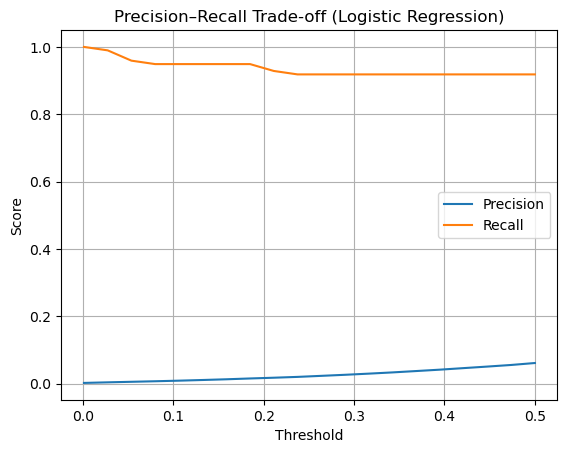

In [95]:
plt.figure()
plt.plot(threshold_df["threshold"], threshold_df["precision"], label="Precision")
plt.plot(threshold_df["threshold"], threshold_df["recall"], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision–Recall Trade-off (Logistic Regression)")
plt.legend()
plt.grid(True)
plt.show()

Lower threshold → catch more fraud → annoy more customers

Higher threshold → miss fraud → financial loss

Rather than optimizing accuracy, the model is evaluated using ROC-AUC and PR-AUC. Threshold tuning demonstrates how recall can be increased at the cost of false positives, reflecting real-world fraud detection trade-offs.

# Random Forest (non-linear baseline)

In [96]:
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=20,
    class_weight="balanced_subsample",
    random_state=42,
    n_jobs=-1
)

In [97]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', max_depth=12,
                       min_samples_leaf=20, n_estimators=300, n_jobs=-1,
                       random_state=42)

In [98]:
rf_test_proba = rf.predict_proba(X_test)[:, 1]

In [99]:
rf_results = evaluate_scores(y_test, rf_test_proba, threshold=0.5)

print("Random Forest ROC-AUC:", rf_results["roc_auc"])
print("Random Forest PR-AUC :", rf_results["pr_auc"])
print("\nConfusion Matrix:\n", rf_results["confusion_matrix"])
print("\nClassification Report:\n", rf_results["report"])

Random Forest ROC-AUC: 0.9639103108885648
Random Forest PR-AUC : 0.7846461824893386

Confusion Matrix:
 [[56834    30]
 [   16    82]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9997    0.9995    0.9996     56864
           1     0.7321    0.8367    0.7810        98

    accuracy                         0.9992     56962
   macro avg     0.8659    0.9181    0.8903     56962
weighted avg     0.9993    0.9992    0.9992     56962



# Logistic vs Random Forest

In [100]:
comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest"],
    "ROC_AUC": [baseline_results["roc_auc"], rf_results["roc_auc"]],
    "PR_AUC":  [baseline_results["pr_auc"], rf_results["pr_auc"]]
})

comparison

,Model,ROC_AUC,PR_AUC
0,Logistic Regression,0.972169,0.715912
1,Random Forest,0.963910,0.784646


Random Forest improves discrimination by capturing non-linear patterns, but introduces a higher false-positive rate at default thresholds.

# Feature importance

In [101]:
importances = pd.Series(
    rf.feature_importances_,
    index=X_train.columns
).sort_values(ascending=False)

importances.head(10)

V14    0.166268
V4     0.121724
V10    0.116630
V12    0.099239
V17    0.082147
V11    0.065697
V3     0.055163
V16    0.051834
V7     0.028686
V2     0.027117
dtype: float64

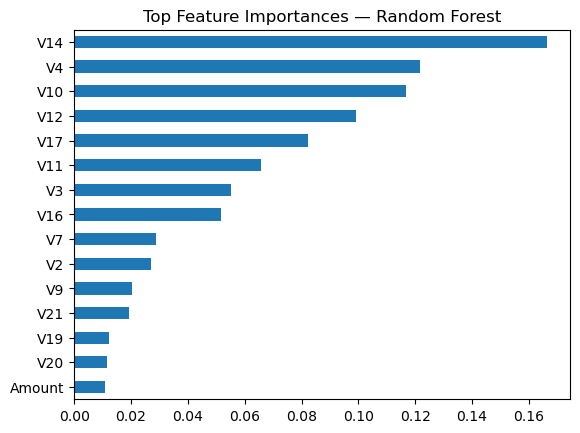

In [102]:
plt.figure()
importances.head(15).plot(kind="barh")
plt.title("Top Feature Importances — Random Forest")
plt.gca().invert_yaxis()
plt.show()

# Threshold tuning

In [103]:
thresholds = np.linspace(0.001, 0.3, 15)

rows = []
for t in thresholds:
    res = evaluate_scores(y_test, rf_test_proba, threshold=t)
    tn, fp, fn, tp = res["confusion_matrix"].ravel()
    rows.append({
        "threshold": t,
        "precision": tp / (tp + fp + 1e-9),
        "recall": tp / (tp + fn + 1e-9),
        "false_positives": fp
    })

rf_thresholds = pd.DataFrame(rows)
rf_thresholds

,threshold,precision,recall,false_positives
0,0.001000,0.002139,0.989796,45241
1,0.022357,0.020919,0.938776,4306
2,0.043714,0.048581,0.908163,1743
3,0.065071,0.091942,0.908163,879
4,0.086429,0.153448,0.908163,491
5,0.107786,0.205607,0.897959,340
6,0.129143,0.260355,0.897959,250
7,0.150500,0.323529,0.897959,184
8,0.171857,0.372881,0.897959,148
9,0.193214,0.413146,0.897959,125


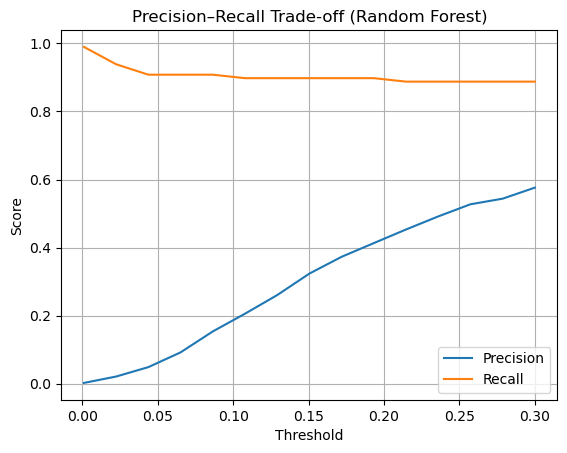

In [104]:
plt.figure()
plt.plot(rf_thresholds["threshold"], rf_thresholds["precision"], label="Precision")
plt.plot(rf_thresholds["threshold"], rf_thresholds["recall"], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision–Recall Trade-off (Random Forest)")
plt.legend()
plt.grid(True)
plt.show()

# XGBoost

In [105]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
scale_pos_weight

577.2868020304569

In [106]:
xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    eval_metric="aucpr",
    random_state=42,
    n_jobs=-1
)

In [107]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=-1, num_parallel_tree=None, ...)

In [108]:
xgb_test_proba = xgb.predict_proba(X_test)[:, 1]

xgb_results = evaluate_scores(y_test, xgb_test_proba, threshold=0.5)

print("XGBoost ROC-AUC:", xgb_results["roc_auc"])
print("XGBoost PR-AUC :", xgb_results["pr_auc"])
print("\nConfusion Matrix:\n", xgb_results["confusion_matrix"])

XGBoost ROC-AUC: 0.9789838698563273
XGBoost PR-AUC : 0.8767424155009337

Confusion Matrix:
 [[56850    14]
 [   17    81]]


In [109]:
final_comparison = pd.DataFrame({
    "Model": ["Logistic Regression", "Random Forest", "XGBoost"],
    "ROC_AUC": [
        baseline_results["roc_auc"],
        rf_results["roc_auc"],
        xgb_results["roc_auc"]
    ],
    "PR_AUC": [
        baseline_results["pr_auc"],
        rf_results["pr_auc"],
        xgb_results["pr_auc"]
    ]
})

final_comparison

,Model,ROC_AUC,PR_AUC
0,Logistic Regression,0.972169,0.715912
1,Random Forest,0.963910,0.784646
2,XGBoost,0.978984,0.876742


While Logistic Regression provides a transparent and stable baseline, tree-based models capture complex non-linear fraud patterns. XGBoost delivers the best precision–recall trade-off, making it suitable for high-risk transaction screening when combined with threshold optimization.

In [110]:
rng = np.random.RandomState(42)

background_size = 2000
explain_size = 5000

background_idx = rng.choice(len(X_train), size=min(background_size, len(X_train)), replace=False)
explain_idx = rng.choice(len(X_test), size=min(explain_size, len(X_test)), replace=False)

X_background = X_train.iloc[background_idx]
X_explain = X_test.iloc[explain_idx]
y_explain = y_test.iloc[explain_idx]

In [111]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_explain)

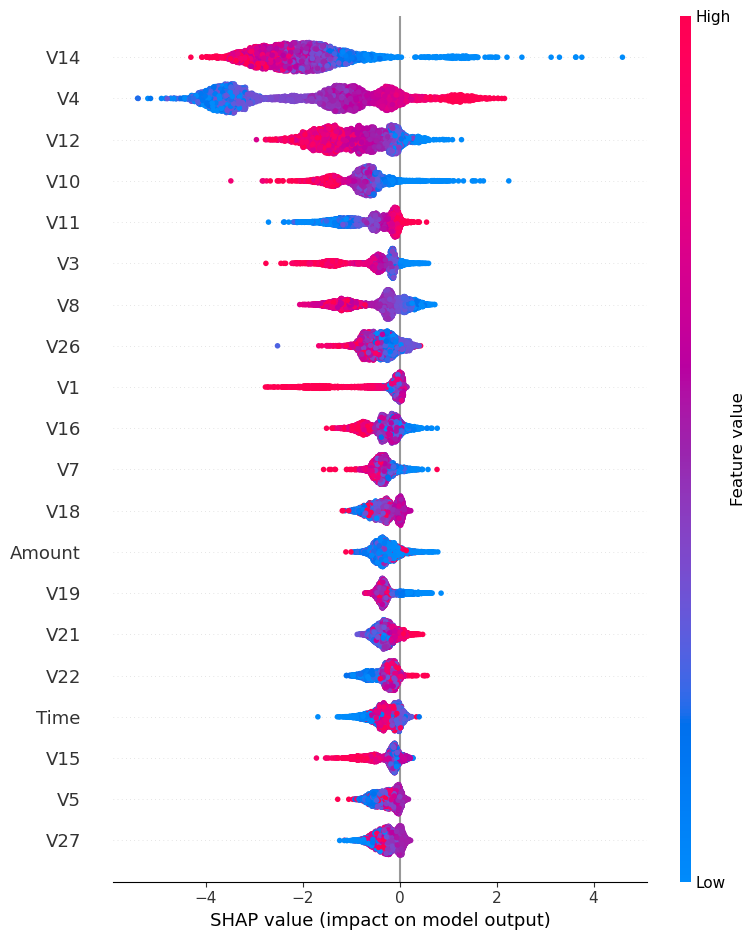

In [112]:
shap.summary_plot(shap_values, X_explain, show=True)

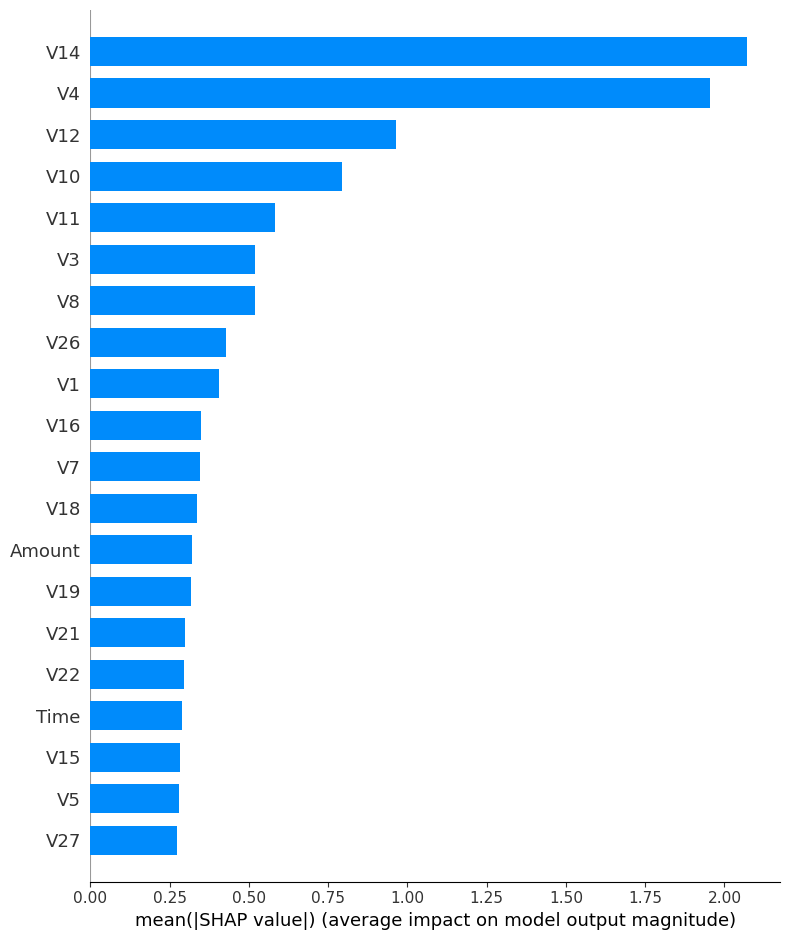

In [113]:
shap.summary_plot(shap_values, X_explain, plot_type="bar", show=True)

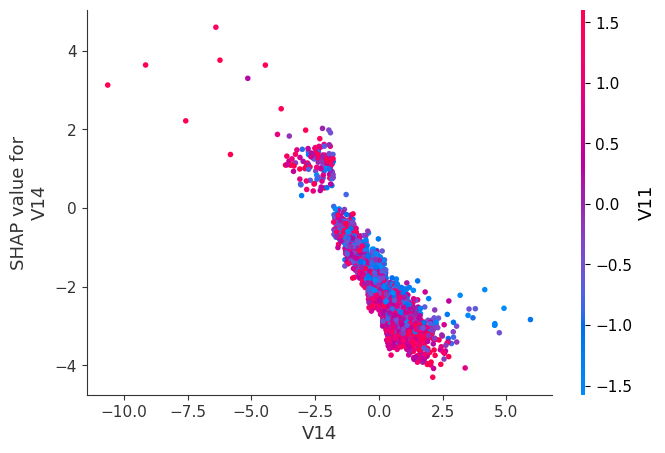

In [114]:
shap.dependence_plot("V14", shap_values, X_explain, show=True)

# Local explanation: ONE transaction

In [115]:
i = 0  # change this
row = X_explain.iloc[i:i+1]

pred_proba = xgb.predict_proba(row)[:, 1][0]
print("Predicted fraud probability:", pred_proba)

Predicted fraud probability: 0.0017398951


# Waterfall plot

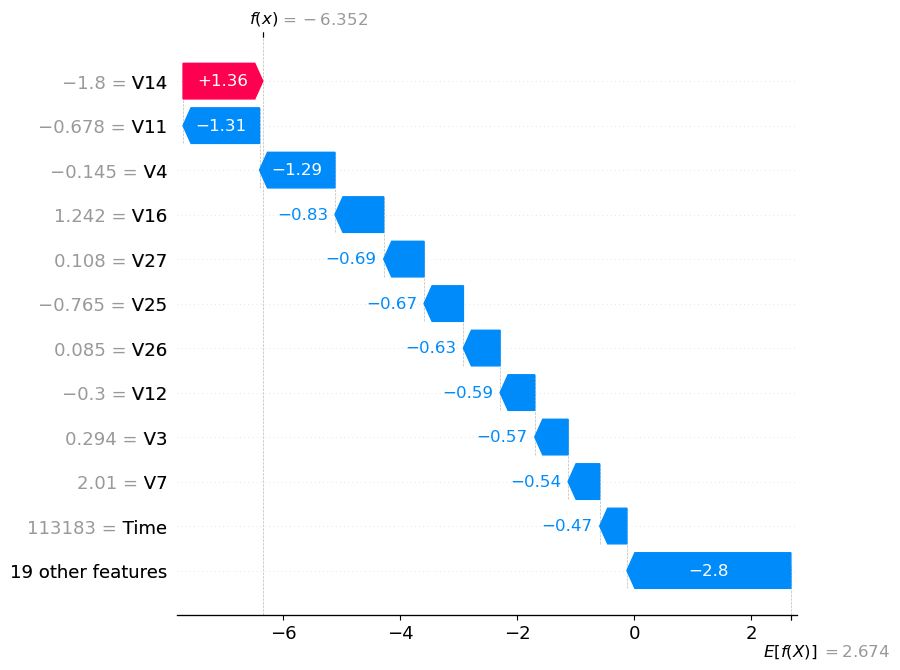

In [116]:
shap_row = shap_values[i]
base_value = explainer.expected_value  # baseline log-odds for XGB binary

exp = shap.Explanation(values=shap_row, base_values=base_value, data=row.values[0], feature_names=row.columns)

shap.plots.waterfall(exp, max_display=12)

# Force plot

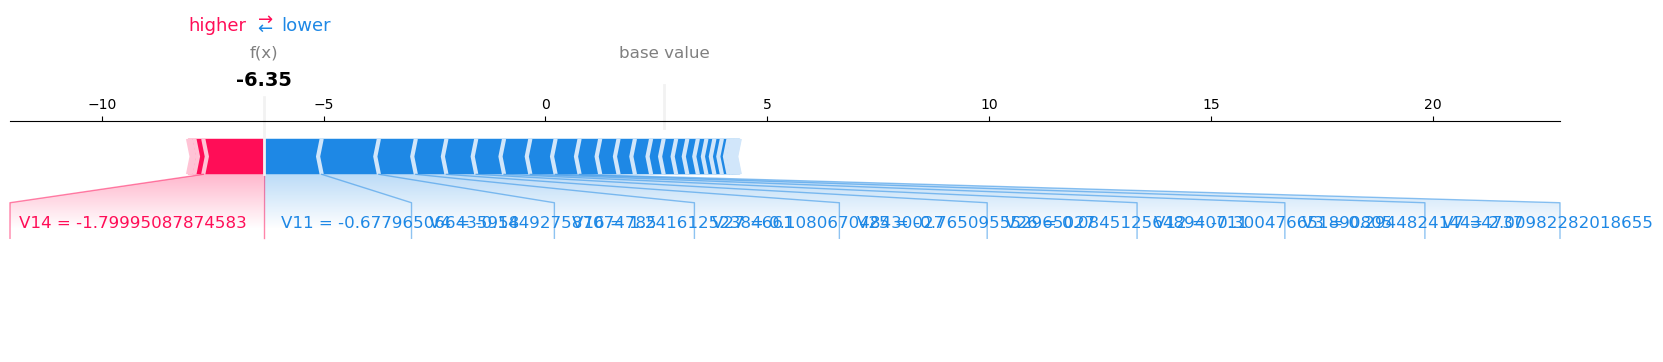

In [117]:
shap.initjs()
shap.force_plot(base_value, shap_row, row, matplotlib=True)

<Figure size 2400x1080 with 0 Axes>

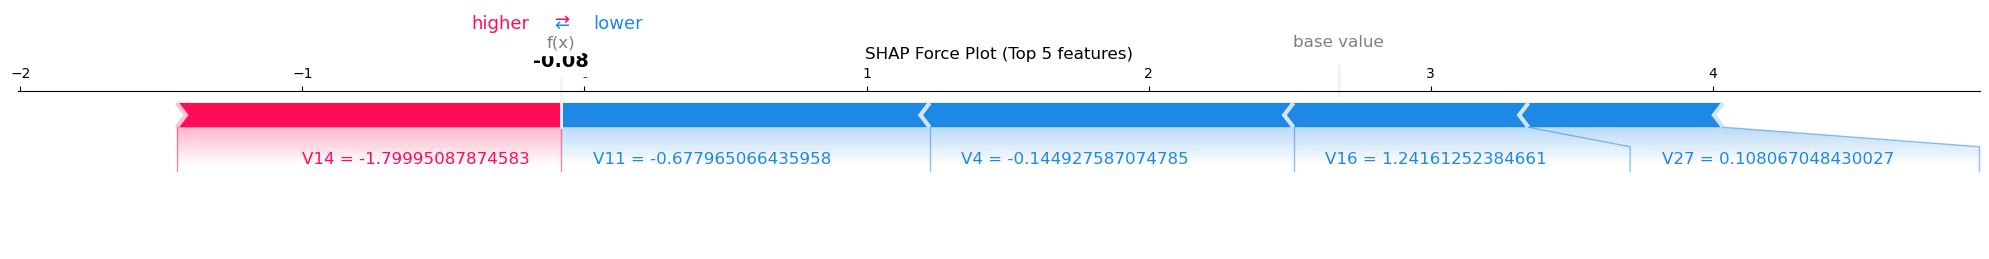

In [118]:
K = 5  # number of features to show

vals = row.iloc[0].values
names = row.columns
sv = shap_row  # shap values for that row

top_idx = np.argsort(np.abs(sv))[::-1][:K]

sv_top = sv[top_idx]
vals_top = vals[top_idx]
names_top = names[top_idx]

plt.figure(figsize=(24, 10.8))
shap.force_plot(
    base_value,
    sv_top,
    vals_top,
    feature_names=names_top,
    matplotlib=True,
    show=False
)
plt.title(f"SHAP Force Plot (Top {K} features)")
plt.tight_layout()
plt.show()

Here’s what drives the model specifically on actual fraud cases.

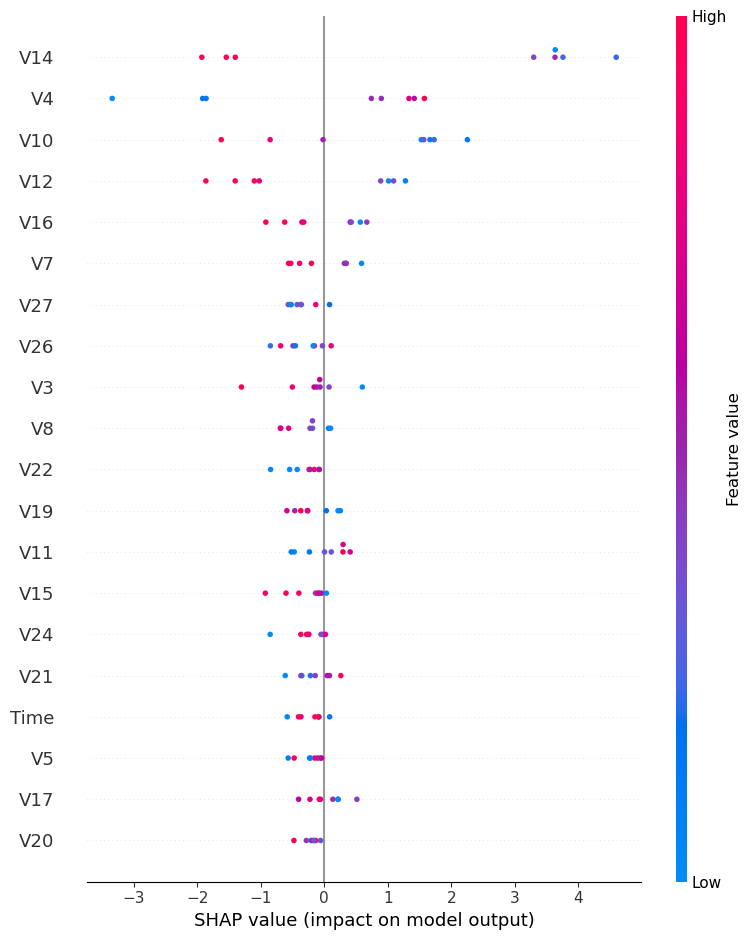

In [119]:
fraud_mask = (y_explain == 1).values
X_fraud = X_explain[fraud_mask]

if len(X_fraud) > 0:
    shap_fraud = explainer.shap_values(X_fraud)
    shap.summary_plot(shap_fraud, X_fraud, show=True)
else:
    print("No fraud cases in the explanation sample — increase explain_size.")